# Trabajo: Minería de texto
#### Daniel Marín López, Guadalupe Luna Velázquez

#### Marta López Urbano, Víctor Páez Anguita

## Introducción
### ¿Qué es la mineria de texto?

La **minería de texto** es el proceso de transformar el texto no estructurado en una forma estructurada que ayude a identificar patrones significativos y nueva información.

Trabajar con datos no estructurados es una tarea para la IA, y si juntamos el análisis de texto entonces estamos ante un claro caso de NLP.

Algunos ejemplos clásicos son la identificación de correos con SPAM, análisis de sentimientos o, incluso, la minería de opiniones para las plataformas como IMDb.

---

## Se pide...

Realizar un sistema que al pasarle una letra de una canción detecte si pertenece a un género o no. En nuestro caso intentaremos que detecte el género pop.

## Como abordar el problema

Para poder abordar el problema se puede hacer de la siguiente forma:

1. **Recolección de datos**
2. **Preprocesamiento del texto**
  1. Limpieza de datos
  2. Tokenización
  3. Lematización/Stemming
  4. Eliminación de palabras vacías (stop words)
3. **Representación del texto**
  1. Bag of Words (BoW)
  2. TF-IDF
  3. Embeddings
4. **Selección del modelo**
5. **Entrenamiento y validación**
6. **Pruebas**

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
# import spacy

## 1. Recolección de datos

Lo primero será recolectar el dataset que vamos a utilizar que tenga recopiladas un montón de canciones con su género respectivo.

Primero descargamos los datos y los descomprimimos.



```python
os.makedirs("/content/data/.kaggle", exist_ok=True)
!mv /content/kaggle.json /content/.kaggle/
!chmod 600 /content/data/.kaggle/kaggle.json

# Descarga el dataset
!kaggle datasets download -d carlosgdcj/genius-song-lyrics-with-language-informatio
with zipfile.ZipFile("genius-song-lyrics-with-language-information.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

# Borramos el archivo zip

os.remove("/content/genius-song-lyrics-with-language-information.zip")
```



Una vez se han descargado los datos, los guardamos en un DataFrame de Pandas. Debido a la magnitud inmensa de los datos, optaremos por filtrar por la canciones cuyo idioma sea inglés para que nuestro dataset sea minimamente procesado.

```python
chunk_size = 100000  # Define el tamaño del chunk
chunks = []

for chunk in pd.read_csv('/content/data/song_lyrics.csv', chunksize=chunk_size):
    # Procesar cada chunk (por ejemplo, filtrar por idioma o género)
    chunk = chunk[(chunk['language'] == 'en')]
    chunks.append(chunk)

# Combina los chunks si es necesario
df = pd.concat(chunks)
df
```






Como opcional, vamos a guardar el DataFrame en un csv en nuestro Drive de forma que el tema de la memoria no sea un problema.


```python
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
os.makedirs(ruta, exist_ok=True)
ruta_archivo = os.path.join(ruta, 'en_lyrics.csv')
df.to_csv(ruta_archivo, index=False)
```
Y por último podemos cargar el archivo filtrado desde drive sin tener que procesarlo entero de nuevo.

In [2]:
# Load the preprocessed data
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'pop_comb.csv')
df = pd.read_csv(ruta_archivo)
df

Mounted at /content/drive


,tag,lyrics
0,pop,wanting you to know youve lost all taste disre...
1,pop,can we talk now i need to tell you whats on my...
2,pop,how does it feel when youre left sitting out i...
3,pop,dear master suzuki i am writing you today you ...
4,pop,confessions of the brakemans son vindicating s...
...,...,...
59995,country,you be coming through you be coming through th...
59996,country,suns going to shine in my back door some day m...
59997,country,you want this yea and the timings so right bit...
59998,country,hello darlin my its good to hear you im at the...


## 2. Preprocesamiento

El siguiente paso será realizar un preprocesado de nuestro dataset. Aquí hay distintas cosas que podemos realizar como limpieza, tokenización, etc.

#### 1. Limpieza
Empezaremos con una limpieza de la letra para eliminar sobre todo mayúsculas. También podemos reducir la dimensionalidad para quedarnos solo con el género y la letra.



```python
df = df
print(df.info())

"""
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   title          59998 non-null  object
 1   tag            60000 non-null  object
 2   artist         60000 non-null  object
 3   year           60000 non-null  int64
 4   views          60000 non-null  int64
 5   features       60000 non-null  object
 6   lyrics         60000 non-null  object
 7   id             60000 non-null  int64
 8   language_cld3  60000 non-null  object
 9   language_ft    60000 non-null  object
 10  language       60000 non-null  object
dtypes: int64(3), object(8)
memory usage: 5.0+ MB
None
"""
```




```python
del df['title']
del df['features']
del df['views']
del df['year']
del df['artist']
del df['language_cld3']
del df['language']
del df['language_ft']
del df['id']
df
```



```python
import re

def preprocess_text(text):
  text = re.sub(r"\[.*?\]", "", text)
  text = re.sub(r"\n\s*\n", "\n", text)
  text = text.lower()
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  return text.strip()

df['lyrics'] = df['lyrics'].apply(preprocess_text)
df
```

Miramos cuantos géneros tiene nuestro dataset.

Text(0.5, 1.0, 'Distribución de géneros en el dataset')

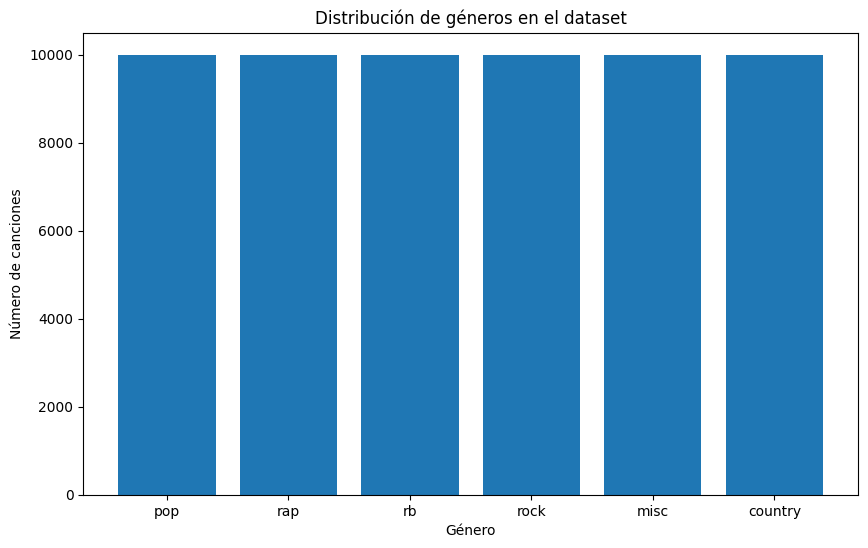

In [3]:
genres = df["tag"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(genres.index, genres.values)
plt.xlabel("Género")
plt.ylabel("Número de canciones")
plt.title("Distribución de géneros en el dataset")

Podemos apreciar con esta tabla los distintos géneros que se encuentran en el dataset. Nosotros trabajaremos con el género pop a detectar y el resto los cortaremos a 2000 registros cada uno y los reasignaremos a la categoría "non-pop".

In [4]:
# Assuming 'df' is your DataFrame and it has a column named 'tag'
non_pop_genres = df[df['tag'] != 'pop']
max_non_pop = 2000

# Group by genre and sample up to max_non_pop
sampled_non_pop = non_pop_genres.groupby('tag').apply(lambda x: x.sample(min(len(x), max_non_pop))).reset_index(drop=True)

# Change the tag to 'non-pop' for the sampled data
sampled_non_pop['tag'] = 'non-pop'

# Concatenate with the original pop data
pop_data = df[df['tag'] == 'pop']
new_df = pd.concat([pop_data, sampled_non_pop])

<ipython-input-4-c1fd04e35a02>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_non_pop = non_pop_genres.groupby('tag').apply(lambda x: x.sample(min(len(x), max_non_pop))).reset_index(drop=True)


Luego mostramos como ha quedado el dataset final.

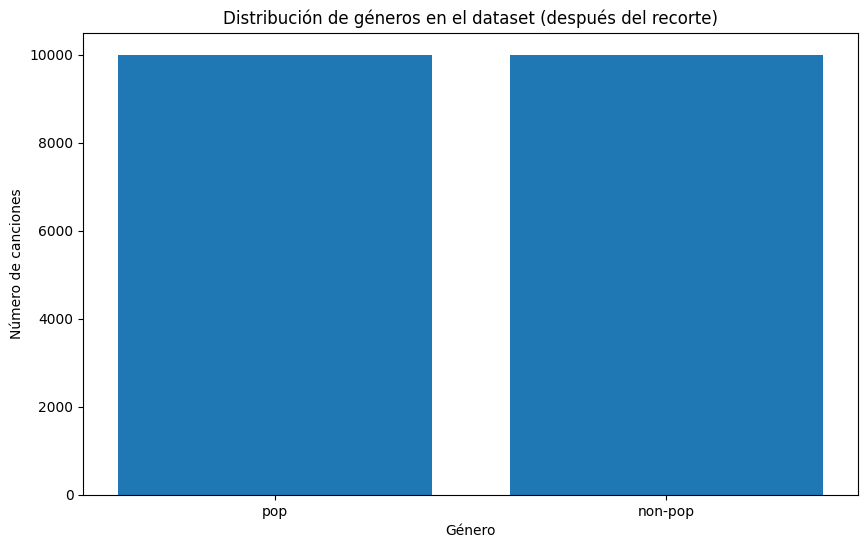

In [5]:
# Display the value counts for verification
genres = new_df["tag"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(genres.index, genres.values)
plt.xlabel("Género")
plt.ylabel("Número de canciones")
plt.title("Distribución de géneros en el dataset (después del recorte)")
plt.show()



```python
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/finish'
ruta_archivo = os.path.join(ruta, 'pop_last.csv')
new_df.to_csv(ruta_archivo, index=False)
```



In [6]:
# Load the preprocessed data
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/finish'
ruta_archivo = os.path.join(ruta, 'pop_last.csv')
new_df = pd.read_csv(ruta_archivo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 2. Tokenización, lematización y stop words

Lo siguiente será procesar el texto resultante de cada letra y extraer las palabras claves que identifican las letras de estilo pop. Podemos usar para realizar esta labor las librerías `NLTK` y `spaCy`, nosotros usaremos esta última ya que en caso de incluir canciones de otros idiomas es perfecto ya que tiene distintos paquetes dependiendo del idioma.


```python
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Tokenización, lematización y eliminación de stop words
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

tokens = df['lyrics'].apply(preprocess_text)
tokens
```

Al principio lo usabamos pero nos dimos cuenta que TF-IDF daba mejores resultados que este.

Terminado el proceso, se generan en una columna nueva los tokens de las palabras por cada canción.

```python
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'new_pop_2.csv')
df.to_csv(ruta_archivo, index=False)
```

Sin embargo, hay que tener en cuenta estas consideraciones:

* Si el dataset está **desbalanceado**, puede provocar que nuestro modelo favorezca la clase mayoritaria.

```python
# Subsampling
# Get the number of "pop" songs
pop_count = df[df['genre'] == 'pop'].shape[0]

# Randomly sample "non-pop" songs to match the number of "pop" songs
non_pop_df = df[df['genre'] == 'non-pop'].sample(n=pop_count, random_state=42)  # Set random_state for reproducibility

# Concatenate the "pop" songs with the sampled "non-pop" songs
balanced_df = pd.concat([df[df['genre'] == 'pop'], non_pop_df])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Now 'balanced_df' contains an equal number of 'pop' and 'non-pop' songs
genres = balanced_df["genre"].value_counts()
genres
```



## 3. Representación del texto

Ahora podemos intentar usar TF-IDF para buscar palabras que sean más frecuentes en las canciones, esto nos puede dar una pista de que palabras son más frecuentes en las canciones de estilo pop.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_tf = vectorizer.fit_transform(new_df['lyrics'])
feature_names = vectorizer.get_feature_names_out()

# Promedio de TF-IDF por clase
pop_tfidf = X_tf[new_df['tag'] == 'pop'].mean(axis=0).A1 # .A1 converts the resulting matrix into a flattened one-dimensional NumPy array.
other_tfidf = X_tf[new_df['tag'] != 'pop'].mean(axis=0).A1

# Diferencia de importancia
tfidf_diff = pop_tfidf - other_tfidf
relevant_features = sorted(zip(tfidf_diff, feature_names), reverse=True)

print("Palabras o n-gramas más relevantes para 'pop':")
for diff, feature in relevant_features[:10]:
    print(f"{feature}: {diff}")

Palabras o n-gramas más relevantes para 'pop':
youre: 0.006563081236117464
love: 0.006121025994000662
oh: 0.004458935012349313
away: 0.004189336760170808
ill: 0.003653875143654884
chorus: 0.0035769270765021533
theres: 0.003310538297288031
oh oh: 0.0031705015467926017
feel: 0.003155921023132391
heart: 0.0031135683037321754


A continuación haremos una nube de palabras con las 50 palabras más frecuentes en las canciones pop.

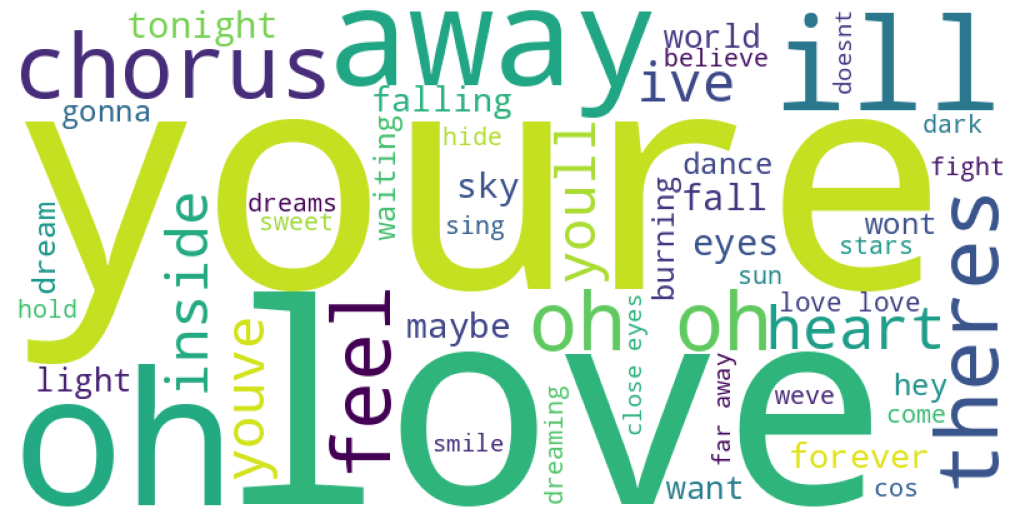

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_freq = {feature: diff for diff, feature in relevant_features[:50]} # Take top 50 for clarity
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

También se puede usar la librería Word2Vec para generar vectores en base a los tokens que generabamos antes para representar el texto a una forma numérica.

```python
from gensim.models import Word2Vec

def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, epochs=10):
    model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, epochs=epochs)
    return model

sentences = df['tokens'].apply(lambda x: x.strip('[]').replace("'", "").split(', ')).tolist()
model = train_word2vec_model(sentences)
```



Provemos a ver como es el vector con la palabra "love".



```python
word_vector = model.wv["love"]
print("Vector para 'love':", word_vector)

"""
Vector para 'love': [ 1.5421209  -1.057031    0.06016188  0.9686033   0.47728133 -2.5916092
  0.6604153   0.38008192 -0.4050451  -1.4620706   0.01230923 -2.5738866
  1.3092611   0.3803202   0.63216865  1.8411928   0.5664323   0.5389144
 -1.2584234   0.73957556 -0.17732283  0.7142853  -1.6885821  -0.23074003
 -0.53766567  0.9771871   0.67522466  0.3035593  -0.6068045   1.5958049
 -1.0368469  -0.6108287   0.15926051 -1.2223814  -1.2256604   2.4666402
 -0.9308293  -1.3514848  -1.8934891  -2.5792499  -0.24301313  1.4152671
  0.44767037 -0.20210703  0.4405086  -0.30869687  0.97072333 -1.2860585
  1.0824164   0.8388727   0.6827698  -0.05902986  1.3612216  -0.47763738
  0.86536586  0.8580091   1.4328394  -0.38854218  1.4963969   1.9419416
 -0.54207754 -1.8025631   0.52928716 -2.330107   -0.8284404   3.1633542
 -1.9180167   2.3457844   0.6423778  -0.4456087  -1.6296196  -0.4057187
 -1.7029157   0.02103424 -0.13207938  0.5535433   0.3252702   0.32164028
 -0.15184537 -2.8128192  -0.0548684  -0.3636386   0.92326283  2.5116413
  1.5984597   0.9232482  -0.6830471  -0.10881469  1.0059901   0.32241794
  0.97663325 -2.1665213  -0.50878817 -0.25764084  0.1370399   0.3558743
  1.2819608   0.05530247 -0.2275207  -1.2481772 ]
"""

```



## 4. Selección de un modelo y entrenamiento

Una vez tenemos una representación adecuada del texto, es momento de escoger un modelo adecuado para entrenar y que sea capaz de identificar si nuestra canción pertenece al género pop o no. Usaremos varios modelos encontrados a lo largo del camino.

##### *¿Que se hacía anteriormente?*

```python
# Function to create document vectors
def document_vector(tokens, model, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

# Generate document vectors
document_vectors = []
for tokens in df['tokens']:
    document_vectors.append(document_vector(tokens, model, 100))

Convert document vectors to a NumPy array
document_vectors = np.concatenate(document_vectors)
```



Anteriormente generabamos una matriz con los vectores de los tokens generados anteriormente por `spaCy` usando `Word2Vec`. Ahora creamos un Dataframe con la matriz del TF-IDF pasada a array cuyas columnas sean cada término encontrado en las lyrics. Aquí creamos los modelos de `LogisticRegression` y `SGDClassifier`, más adelante crearemos otro de redes neuronales llamado `Secuential`.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

tfidf_df = pd.DataFrame(X_tf.toarray(), columns=vectorizer.get_feature_names_out())

# Prepare the data for training
X = tfidf_df
y = new_df['tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
clf = LogisticRegression(max_iter=1000, C=1.0, penalty='l1', solver='liblinear')
clf3 = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)

clf.fit(X_train, y_train)
clf3.partial_fit(X_train, y_train, classes=np.unique(y))
# Predict on the test set
y_pred = clf.predict(X_test)
y_pred3 = clf3.predict(X_test)

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("="*35)
print("\nClassification Report 3:\n", classification_report(y_test, y_pred3))


Classification Report:
               precision    recall  f1-score   support

     non-pop       0.70      0.58      0.64      1981
         pop       0.65      0.75      0.70      2019

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.67      0.67      0.67      4000


Classification Report 3:
               precision    recall  f1-score   support

     non-pop       0.65      0.67      0.66      1981
         pop       0.67      0.65      0.66      2019

    accuracy                           0.66      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.66      0.66      0.66      4000



In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Encode labels to numerical values (0 and 1)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

input_dim = X_train.shape[1]

clf2 = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Salida binaria (pop o no pop)
])
clf2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Use encoded labels for training
clf2.fit(np.array(X_train), np.array(y_train_encoded), epochs=10, batch_size=32, validation_split=0.2)

# Predict and evaluate using encoded labels
y_pred2 = (clf2.predict(np.array(X_test)) > 0.5).astype("int32")
y_pred2_labels = label_encoder.inverse_transform(y_pred2.flatten())
print("\nClassification Report:\n", classification_report(y_test, y_pred2_labels))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5944 - loss: 0.6526 - val_accuracy: 0.6556 - val_loss: 0.6078
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7449 - loss: 0.5229 - val_accuracy: 0.6388 - val_loss: 0.6316
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8199 - loss: 0.4187 - val_accuracy: 0.6331 - val_loss: 0.7244
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8980 - loss: 0.2726 - val_accuracy: 0.6200 - val_loss: 0.9260
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9626 - loss: 0.1241 - val_accuracy: 0.6219 - val_loss: 1.2117
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9852 - loss: 0.0523 - val_accuracy: 0.6122 - val_loss: 1.3828
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9931 - loss: 0.0299 - val_accuracy: 0.6100 - val_loss: 1.7215
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9956 - loss: 0.0177 - val_accu

Vemos que tras generar los vectores de palabras, generar los modelos y entrenarlos obtenemos de desempeño entre un 65% y un 70%. Algo que está bastante bien pero mejorable.

In [ ]:
import pickle

filename_clf = 'logistic_regression_model_1.1a.pkl'
pickle.dump(clf, open(filename_clf, 'wb'))

filename_clf3 = 'sgd_classifier_model_1.1a.pkl'
pickle.dump(clf3, open(filename_clf3, 'wb'))

with open("tfidf_model.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [ ]:
from tensorflow import keras

clf2.save('pop_detected_network_1.1a.h5')

Generaremos las matrices de confusión de los modelos para ver con claridad su desempeño.

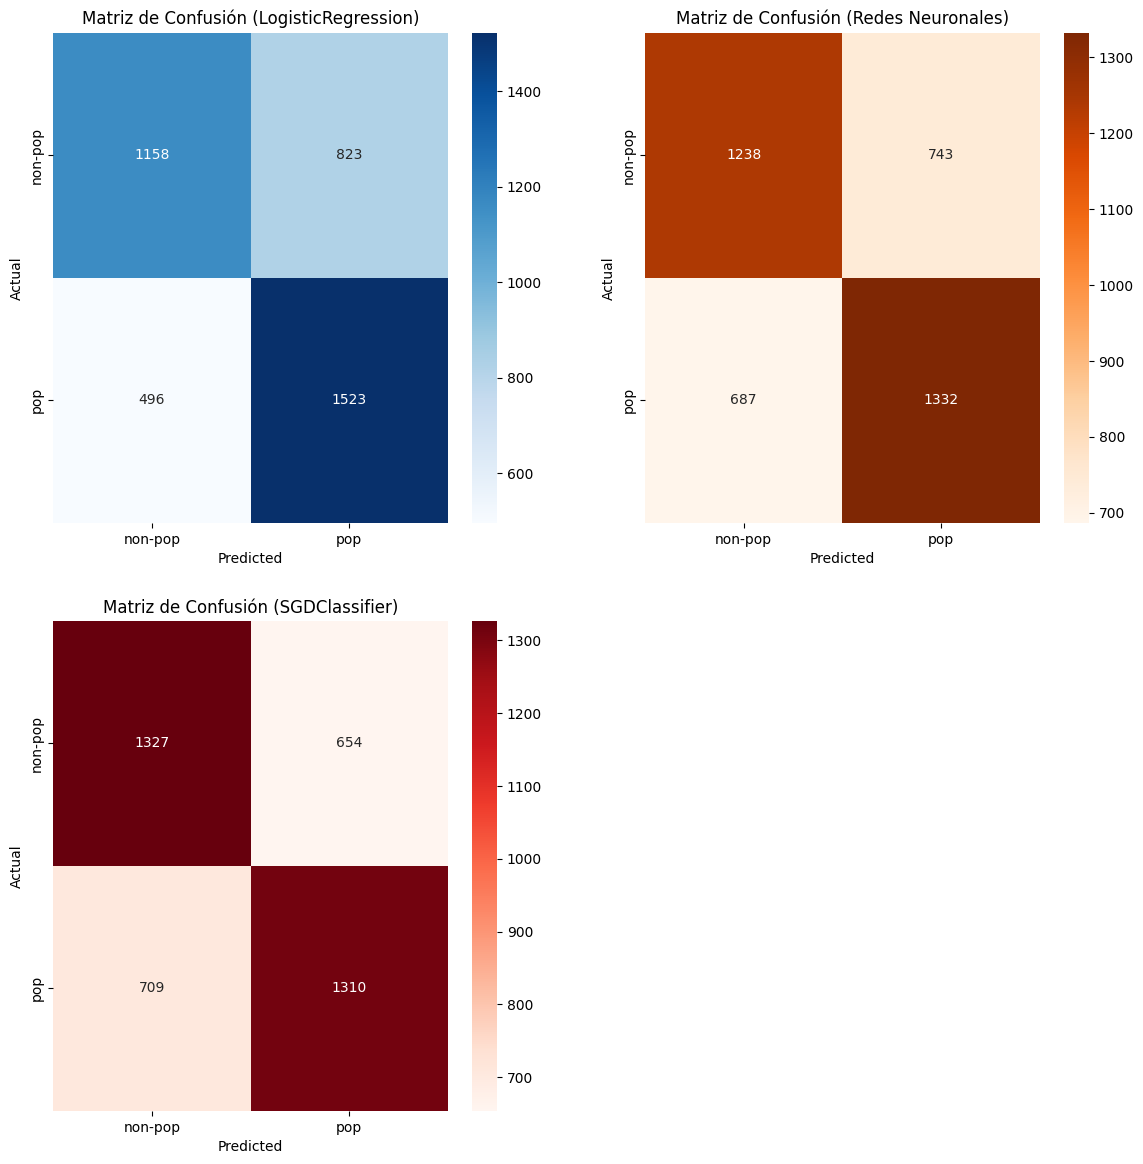

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from the previous code
CLASSES = sorted(new_df['tag'].unique())
cm = confusion_matrix(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred2_labels)
cm3 = confusion_matrix(y_test, y_pred3)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión (LogisticRegression)")

plt.subplot(2, 2, 2)
sns.heatmap(cm2, annot=True, fmt="d", cmap="Oranges",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión (Redes Neuronales)")

plt.subplot(2, 2, 3)
sns.heatmap(cm3, annot=True, fmt="d", cmap="Reds",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión (SGDClassifier)")
plt.show()

La matrices de confusión son bastantes buenas. Los modelos de redes neuronales y `SGDClassifier` han tenido un buen acierto mientras que el de `LogisticRegression` no ha acertado tanto las canciones de género pop.

## 5. Pruebas

Por último, desarrollamos una función que le pida al usuario la letra de una canción y llame a los diferentes modelos para que determinen si la canción pasada es del género pop o no.

In [ ]:
def classify_song():
    lyrics = input("Introduce las lyrics de la canción: ")

    # Vectoriza las lyrics usando el TfidfVectorizer
    lyrics_tfidf = vectorizer.transform([lyrics])

    # Predict using the logistic regression model
    prediction_lr = clf.predict(lyrics_tfidf)[0]

    # Predict using the neural network model
    prediction_nn = (clf2.predict(lyrics_tfidf) > 0.5).astype("int32")[0][0]
    prediction_nn = label_encoder.inverse_transform([prediction_nn])[0]

    # Predict using the SGD Classifier model
    prediction_sgd = clf3.predict(lyrics_tfidf)[0]


    print(f"Predicción con Regresión Logística: {prediction_lr}")
    print(f"Predicción con Red Neuronal: {prediction_nn}")
    print(f"Predicción con SGD Classifier: {prediction_sgd}")

classify_song()

---